In [6]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import simpson
from scipy.interpolate import interp1d

from utils import *
from rotor import Rotor
from bemt import bemt

### Blade Project
- Validate Geometry generation

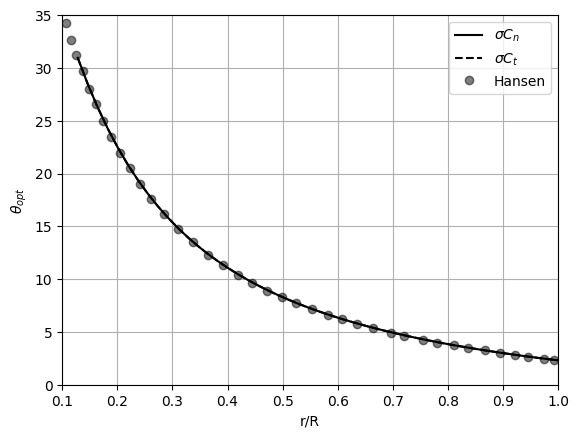

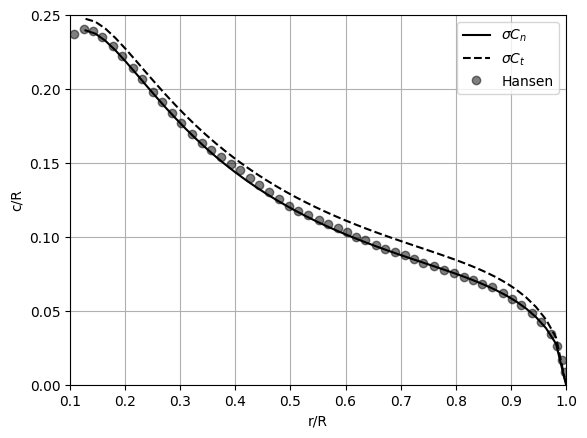

[-0.078 -0.089 -0.104 -0.125 -0.121 -0.139 -0.112 -0.097 -0.112 -0.111
 -0.086 -0.097 -0.13  -0.238 -0.308 -0.375 -0.372 -0.325 -0.26  -0.19
 -0.092 -0.061 -0.098 -0.154 -0.185 -0.19  -0.158 -0.122 -0.079 -0.058
 -0.015  0.019  0.039  0.107  0.145  0.176  0.242  0.309  0.402  0.503
  0.603  0.731  0.964  1.271  1.627  2.103  2.719  3.683]


In [7]:
rotor = Rotor(number_of_blades=3, number_of_sections=50, tip_speed_ratio=6, alpha_opt=4, Cl_opt=0.8, Cd_opt=0.012)
rotor2 = Rotor(number_of_blades=3, number_of_sections=50, tip_speed_ratio=6, alpha_opt=4, Cl_opt=0.8, Cd_opt=0.012)

rotor2.blade_design(r_R0=0.11, plot=False, solidity='Ct')
rotor.blade_design(r_R0=0.11, plot=False, solidity='Cn')

chord_hansen_validate = np.loadtxt(validate_path.joinpath('chord_distribution_Hansen.dat'))
pitch_hansen_validate = np.loadtxt(validate_path.joinpath('pitch_distribution_Hansen.dat'))

# Pitch Angle Distribution

plt.figure(figsize=(6.4, 4.8))
plt.plot(rotor.sections['r_R'], rotor.sections['theta_opt'], 'k', label = r'$\sigma C_n$')
plt.plot(rotor2.sections['r_R'], rotor2.sections['theta_opt'], 'k--', label = r'$\sigma C_t$')
plt.plot(pitch_hansen_validate[:,0], pitch_hansen_validate[:,1],'ko', label = 'Hansen', alpha = 0.5)

plt.xlabel('r/R')
plt.ylabel(r'$\theta_{opt}$')
plt.ylim(0,35)
plt.xlim(0.1, 1)


plt.legend()
plt.grid()
plt.show()

# Chord Distribution
plt.figure(figsize=(6.4, 4.8))
plt.plot(rotor.sections['r_R'], rotor.sections['c_R']*rotor.sections['tip_correction'], 'k', label = r'$\sigma C_n$')
plt.plot(rotor2.sections['r_R'], rotor2.sections['c_R']*rotor2.sections['tip_correction'], 'k--', label = r'$\sigma C_t$')
plt.plot(chord_hansen_validate[:,0], chord_hansen_validate[:,1],'ko', label = 'Hansen', alpha = 0.5)

plt.xlabel('r/R')
plt.ylabel('c/R')
plt.ylim(0,0.25)
plt.xlim(0.1, 1)

plt.legend()
plt.grid()
plt.show()

# Compute Error
code = interp1d(rotor.sections['r_R'], rotor.sections['c_R'], kind='cubic')
hansen = interp1d(chord_hansen_validate[:,0], chord_hansen_validate[:,1], kind='cubic')
error = code(rotor.sections['r_R'][:-1]) - hansen(rotor.sections['r_R'][:-1])
print(np.round(error*100, 3))


- Validate C_P and CT curve for Optimum Blade design

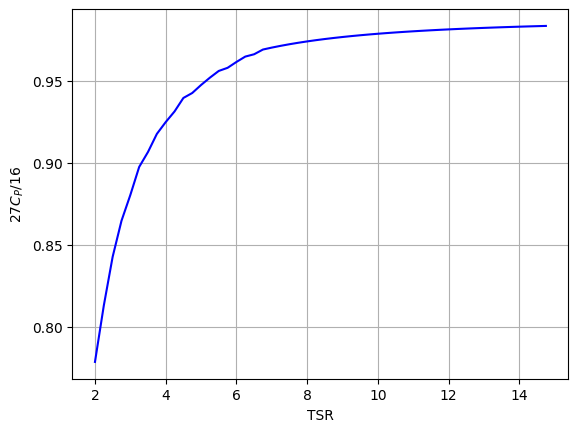

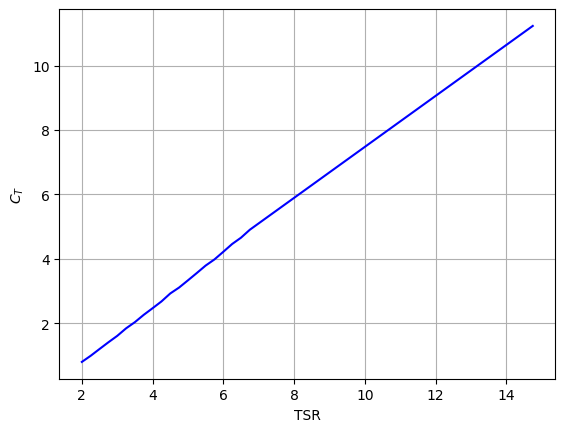

In [8]:
TSR = np.arange(2, 15, 0.25)
CP = np.zeros(len(TSR))
CT = np.zeros(len(TSR))
rotor = Rotor(number_of_blades=2, number_of_sections=100, tip_speed_ratio=2, airfoil_name='s834')
rotor.load_airfoil_prop(plot=False)
for i, tsr in enumerate(TSR):
    rotor.tip_speed_ratio = tsr
    rotor.blade_design(r_R0=0.11, plot=False)
    
    CP[i] = rotor.CP_opt
    CT[i] = rotor.CT_opt

plt.plot(TSR, 27*CP/16, 'b')
plt.xlabel('TSR')
plt.ylabel(r'$27C_P/16$')
plt.grid()
plt.show()

plt.plot(TSR, CT, 'b')
plt.xlabel('TSR')
plt.ylabel(r'$C_T$')
plt.grid()
plt.show()

- Coefficients Extrapolation

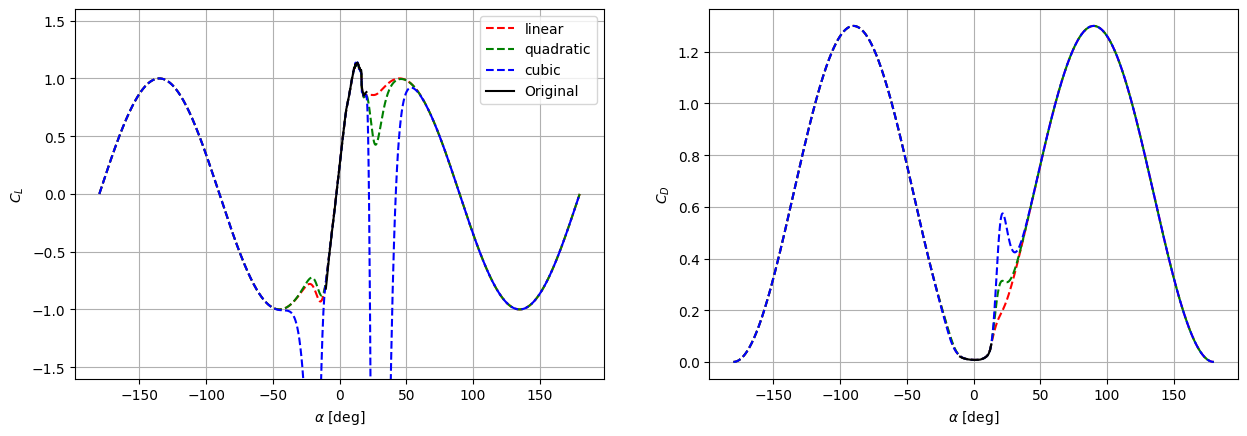

In [9]:
airfoil_name = 's834'
c_lift_drag = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_drg.txt'))
c_lift = process_file(airfoil_path.joinpath(f'{airfoil_name}_c_lft.txt'))

re_drg = list(c_lift_drag.keys())[-1]
re_lft = list(c_lift.keys())[-2:]

Cd = c_lift_drag[re_drg][0][:, 2]
alpha_cd = c_lift_drag[re_drg][0][:, 0]

Cl = np.concatenate([c_lift[re][0][:,1] for re in re_lft])  
alpha_cl = np.concatenate([c_lift[re][0][:,0] for re in re_lft])  

arg = np.argsort(alpha_cl)
alpha_cl = np.sort(alpha_cl)
Cl = Cl[arg]

Cl_mat = np.concatenate((Cl.reshape(-1,1), alpha_cl.reshape(-1,1)), axis = 1)
Cd_mat = np.concatenate((Cd.reshape(-1,1), alpha_cd.reshape(-1,1)), axis = 1)

df_extra_linear = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='linear')
df_extra_quadratic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='quadratic')
df_extra_cubic = coefficients_extrapolation(Cl_mat,Cd_mat, alpha_shift=5, interpolate_type='cubic')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 4.8])

# ax1.plot(df_extra['alpha'],  df_extra['Cl'], 'r--', label = 'Extrapolation')
ax1.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cl'], 'r--',  label = 'linear')
ax1.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cl'], 'g--',  label = 'quadratic')
ax1.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cl'], 'b--',  label = 'cubic')
ax1.plot(alpha_cl,  Cl, 'k',  label = 'Original')

ax1.set_xlabel(r'$\alpha$ [deg]')
ax1.set_ylabel(r'$C_L$')
# ax1.set_xlim([-45, 45])
ax1.set_ylim([-1.6, 1.6])
ax1.legend()
ax1.grid()

# ax2.plot(df_extra['alpha'],  df_extra['Cd'], 'r--', label = 'Extrapolation')
ax2.plot(np.rad2deg(df_extra_linear['alpha']),  df_extra_linear['Cd'], 'r--',  label = 'linear')
ax2.plot(np.rad2deg(df_extra_quadratic['alpha']),  df_extra_quadratic['Cd'], 'g--',  label = 'quadratic')
ax2.plot(np.rad2deg(df_extra_cubic['alpha']),  df_extra_cubic['Cd'], 'b--',  label = 'cubic')
ax2.plot(alpha_cd,  Cd, 'k', label = 'Original')

ax2.set_xlabel(r'$\alpha$ [deg]')
ax2.set_ylabel(r'$C_D$')
# ax2.set_xlim([-25, 25])
# ax2.set_ylim([0, 0.6])
# ax2.legend()
ax2.grid()
# usar g(alpha)_1 para valores positivos e g(alpha)_2 para valores negativos
# alpha +/- 90
plt.show()

- Smooth transition function

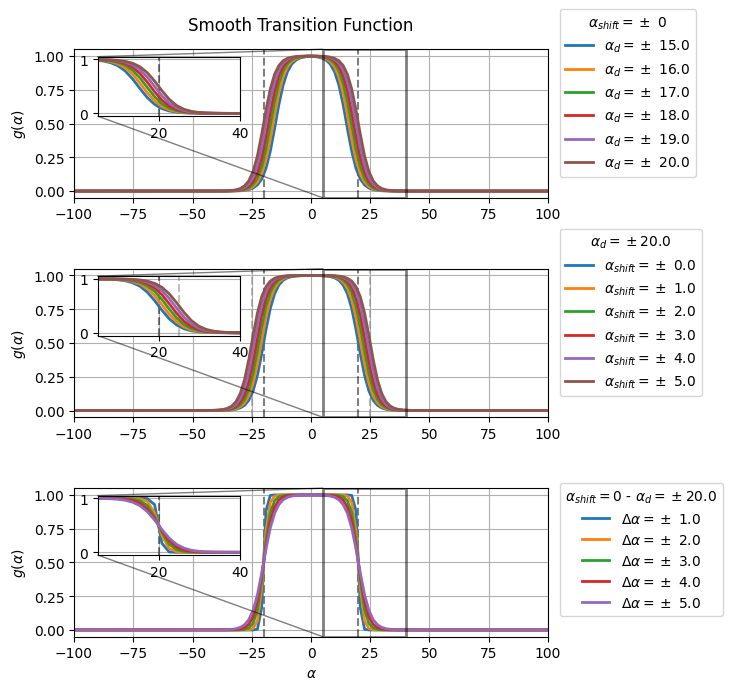

In [10]:
alpha_d = np.deg2rad(20)
alpha_shift = np.deg2rad(5)
delta_alpha = np.deg2rad(5)
alpha = np.linspace(-np.pi, np.pi, 200)


alpha_d_vec = np.deg2rad(np.arange(15, 21))
alpha_shift_vec = np.deg2rad(np.arange(0,6))
delta_alpha_vec = np.deg2rad(np.arange(1, 6))
alpha_vec = np.linspace(-np.pi, np.pi, 200)

g = lambda alpha, alpha_d = alpha_d, alpha_shift = alpha_shift, delta_alpha = delta_alpha: 0.5*(1+np.tanh((alpha_d + alpha_shift  - np.abs(alpha))/delta_alpha))

fig, axis = plt.subplots(3, 1, figsize = [6, 7])
fig.tight_layout(pad=3.0)
fig.suptitle('Smooth Transition Function')
for i, ax in enumerate(axis):
    
    # zoomed plot
    axins = ax.inset_axes([0.05, 0.55, 0.3, 0.4])
    
    # Vertical Lines
    ax.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    ax.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    
    axins.axvline(np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    axins.axvline(-np.rad2deg(alpha_d), linestyle='--', alpha = 0.5, color='black')
    
    if i == 1:
        ax.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        ax.axvline(-np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
    
        axins.axvline(np.rad2deg(alpha_d + alpha_shift), linestyle='--', alpha = 0.5, color='gray')
        axins.axvline(-np.rad2deg(alpha_d +alpha_shift), linestyle='--', alpha = 0.5, color='gray')


    # Effect of change parameter in smooth transition function
    
    if i == 0:
        for alpha_d in alpha_d_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_d = alpha_d, alpha_shift=0), linewidth=2, label=r'$\alpha_d = \pm$ ' + f'{np.rad2deg(alpha_d):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_d=alpha_d, alpha_shift=0), linewidth=2)
            # ax.set_title('Smooth Transition function')
            title = r'$\alpha_{shift} = \pm$ 0'
    elif i == 1:
        for alpha_shift in alpha_shift_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift = alpha_shift), linewidth=2, label=r'$\alpha_{shift} = \pm$ ' + f'{np.rad2deg(alpha_shift):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=alpha_shift), linewidth=2)
            title = r'$\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    elif i == 2:
        for delta_alpha in delta_alpha_vec:
            ax.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha = delta_alpha), linewidth=2, label=r'$\Delta \alpha = \pm$ ' + f'{np.rad2deg(delta_alpha):.1f}')
            axins.plot(np.rad2deg(alpha), g(alpha, alpha_shift=0, delta_alpha=delta_alpha), linewidth=2)
            ax.set_xlabel(r'$\alpha$')
            title = r'$\alpha_{shift} = 0$ - $\alpha_d = \pm $' + f'{np.rad2deg(alpha_d):.1f}'
    # else:
    #     ax.plot(np.rad2deg(alpha), g(alpha), linewidth=2, color='black', label=r'$g(\alpha)$')


    ax.set_ylabel(r'$g(\alpha)$')
    # ax.set_xticks(np.arange(-180,190,10))
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.set_xlim([-100, 100])
    ax.legend(title = title, bbox_to_anchor=(1.01, 0.095))
    ax.grid()

    axins.set_xlim(5, 40)
    axins.grid()

    ax.indicate_inset_zoom(axins, linewidth=2, edgecolor="black")

plt.show()


### Validate BEMT

In [11]:
rotor = Rotor(number_of_blades=2, number_of_sections=100, tip_speed_ratio=7, airfoil_name='s834', tip_correction_model='')
rotor.load_airfoil_prop(plot=False)
rotor.blade_design(r_R0=0.3, plot=False)

# Without Drag losses and tip correction
results = bemt(rotor=rotor, TSR=np.arange(2, 14, 0.25), iter=500, tol=1e-3, tip_correction_model='', Cd_null=True)

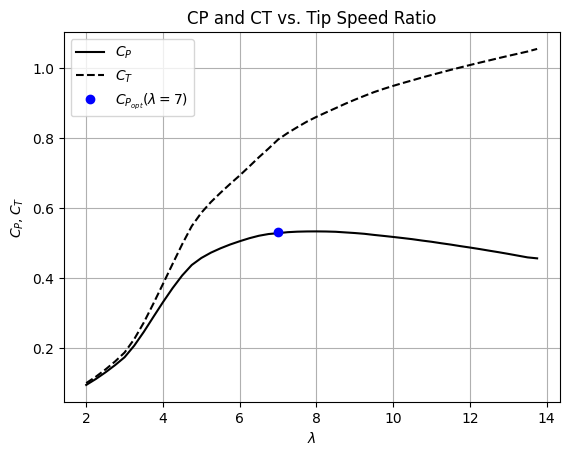

In [12]:
plt.plot(results.TSR, results.CP, 'k', label = r'$C_P$')
plt.plot(results.TSR, results.CT, 'k--', label = r'$C_T$')
plt.plot(rotor.tip_speed_ratio, rotor.CP_opt, 'bo', label = r'$C_{P_{opt}}(\lambda = 7)$')

plt.title('CP and CT vs. Tip Speed Ratio')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$C_P, C_T$')

plt.grid()
plt.legend()
plt.show()